In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.integrate import odeint
import seaborn as sns
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_scfa = pd.read_excel('../../../../../data/SCFA.xlsx', index_col=0)
df_scfa = df_scfa[['Acetate','Butyrate','Propionate']]
df_meta = pd.read_excel('../../../../../data/meta_data.xlsx', index_col=0)
df_meta.loc[df_meta.MiceID=='HI5','MiceID'] = 'HI3'
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_meta = df_scfa_meta[df_scfa_meta.Diet=='Inulin']
df_scfa_meta.head()

,MiceID,Vendor,Day,Diet,Acetate,Butyrate,Propionate
SampleID,,,,,,,
sample141,BI1,Beijing,0,Inulin,5.233899,1.109582,1.930933
sample142,BI2,Beijing,0,Inulin,13.459823,1.546647,3.621771
sample143,BI3,Beijing,0,Inulin,18.075378,1.682656,2.859916
sample144,BI4,Beijing,0,Inulin,12.580368,1.477688,3.148773
sample145,BI5,Beijing,0,Inulin,8.065127,1.835172,3.134209


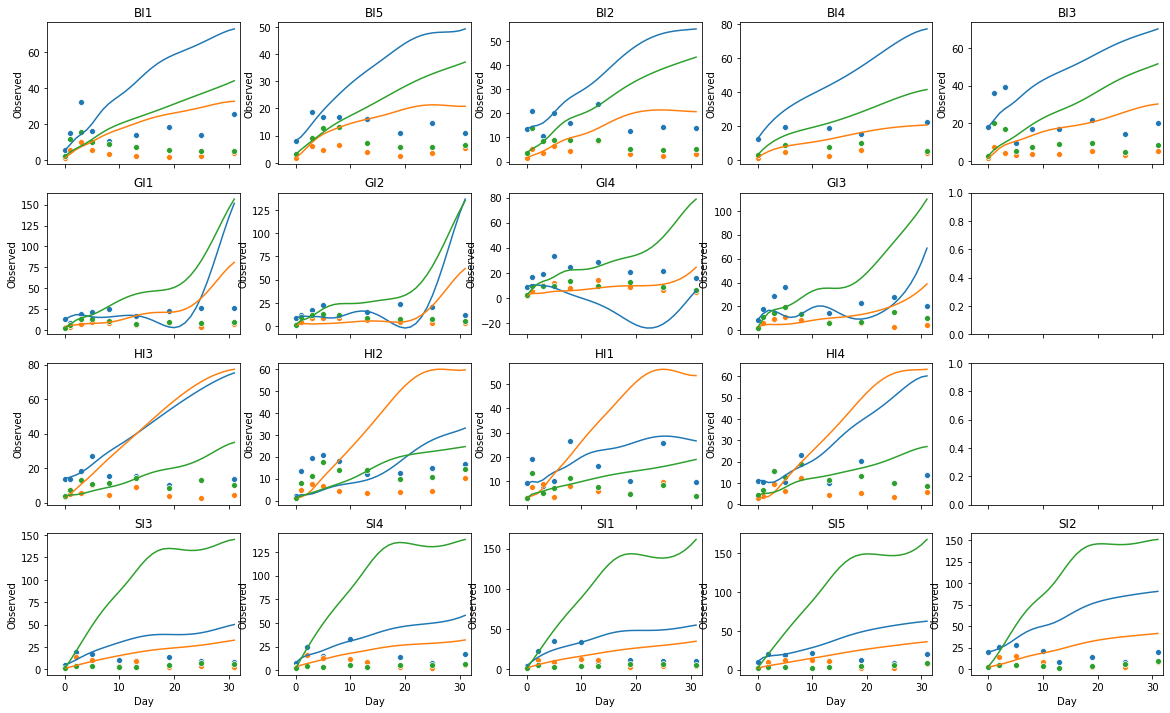

In [5]:
fig, ax = plt.subplots(figsize=(20, 12), nrows=4, ncols=5, sharex=True)

df_pred_all = None
count=1
Vendors = ['Beijing','Guangdong','Hunan','Shanghai']
for directory in ['leave_BJ_out','leave_GD_out','leave_HN_out','leave_SH_out']:
    vendor = Vendors[count-1]
    df_16S = pd.read_excel('../../../../../data/16S_absolute_abundance.xlsx', index_col=0)
    df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
    df_X = pd.read_csv('%s/top40_absab/independent_variables_top40.csv'%(directory), index_col=0)
    df_16S = df_16S[df_X.columns]
    df_meta = pd.read_excel('../../../../../data/meta_data.xlsx', index_col=0)
    df_meta.loc[df_meta.MiceID=='HI5','MiceID'] = 'HI3'
    df_meta = df_meta.loc[df_scfa_meta.index]
    df_16S_meta = pd.merge(df_meta, df_16S, left_index=True, right_index=True, how='inner')
    df_16S_meta = df_16S_meta[df_16S_meta.Diet=='Inulin']
    df_opt_paras = pd.read_excel('%s/top40_absab/optimal_rf_hyperparameters_top40.xlsx'%(directory), index_col=0)
    df_Y = pd.read_csv('%s/top40_absab/response_variables_scfa_deriv.csv'%(directory), index_col=0)

    df_res = None
    for scfa in ['Acetate','Butyrate','Propionate']:
        dydt = np.asarray(list(df_Y[scfa]))
        X = np.asarray(df_X.values)
        regr = RandomForestRegressor(
            random_state=0,
            bootstrap=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'bootstrap'])[0],
            max_depth=None if str(list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0])=='nan' else list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0],
            max_features=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_features'])[0],
            min_samples_leaf=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_leaf'])[0],
            min_samples_split=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_split'])[0],
            n_estimators=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'n_estimators'])[0],
            n_jobs=-1
        )
        clf = regr.fit(X, dydt)
        curr_X = df_16S_meta.iloc[:,4:].values
        pred_Y = regr.predict(curr_X)
        curr_df = df_16S_meta.iloc[:,[0,1,2,3]]
        curr_df['SCFA'] = scfa
        curr_df['Deriv'] = pred_Y
        curr_df = curr_df[curr_df.Vendor==vendor]
        if df_res is None:
            df_res = curr_df
        else:
            df_res = pd.concat([df_res, curr_df])
    
    lines = []
    for curr_vendor in list(set(df_res.Vendor)):
        all_mice = list(set(df_res.loc[df_res.Vendor==curr_vendor,'MiceID']))
        for curr_mice in all_mice:
            for scfa in ['Acetate','Butyrate','Propionate']:
                curr_df = df_res[(df_res.MiceID==curr_mice)&(df_res.SCFA==scfa)].sort_values(by='Day')
                cs = CubicSpline(curr_df.Day, curr_df.Deriv)
                day0_observed = df_scfa_meta.loc[(df_scfa_meta.Vendor==curr_vendor) & (df_scfa_meta.MiceID==curr_mice) & (df_scfa_meta.Day==0),scfa].values[0]
                day0_simulated = day0_observed 
                lines.append([curr_mice, curr_vendor, 0, scfa, day0_observed, day0_simulated])
                for day in np.arange(1,32):
                    observed_value = df_scfa_meta.loc[(df_scfa_meta.Vendor==curr_vendor) & (df_scfa_meta.MiceID==curr_mice) & (df_scfa_meta.Day==day),scfa]
                    if len(observed_value) == 0:
                        lines.append([curr_mice, curr_vendor, day, scfa, np.NaN, day0_simulated+cs.integrate(0,day)])
                    else:
                        observed_value = observed_value.values[0] 
                        lines.append([curr_mice, curr_vendor, day, scfa, observed_value, day0_simulated+cs.integrate(0,day)])
    df_pred = pd.DataFrame(lines, columns=['MiceID','Vendor','Day','SCFA','Observed','Predicted'])
    
    if count==1:
        df_pred_all = df_pred
    else:
        df_pred_all = pd.concat([df_pred_all, df_pred], ignore_index=True)

    # plot prediction
    for idx_j, mice in enumerate(set(df_pred.MiceID)):
        curr_df = df_pred[df_pred.MiceID==mice].sort_values(['SCFA','Day'])
        sns.lineplot(x='Day',y='Observed', hue='SCFA', marker='o', data=curr_df, ax=ax[count-1,idx_j], linestyle='None')
        sns.lineplot(x='Day',y='Predicted',hue='SCFA', data=curr_df, ax=ax[count-1,idx_j])
        ax[count-1,idx_j].set_title(mice)
        ax[count-1,idx_j].set_xlim([-3.2,32])
        ax[count-1,idx_j].set_xlim([-3.2,32])
        ax[count-1,idx_j].get_legend().remove()
    
    count +=1

(-30.0, 180.0)

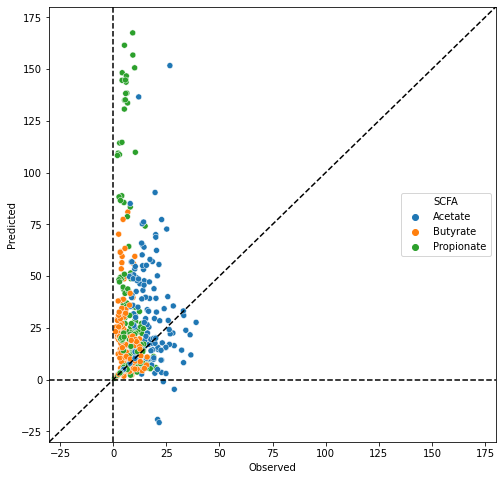

In [8]:
fig, ax = plt.subplots(figsize=(8, 8), nrows=1, ncols=1)

df_pred_all_corrected = deepcopy(df_pred_all.dropna())
#df_pred_all_corrected.loc[df_pred_all_corrected.Predicted<0, 'Predicted'] = 0

_ = sns.scatterplot(x='Observed', y='Predicted', hue='SCFA', data=df_pred_all_corrected, ax=ax)
ax.plot([-30,180],[0,0], 'k--')
ax.plot([0,0], [-30,180], 'k--')
ax.plot([-30,180], [-30,180], 'k--')
ax.set_xlim([-30,180])
ax.set_ylim([-30,180])

In [9]:
pearsonr(df_pred_all_corrected['Observed'], df_pred_all.dropna()['Predicted'])

(-0.05568484526065124, 0.2353222382524662)